# Cifar10 solved with ResNet
### A computer vision model for image classification.

Import necessary libraries


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
import random
import numpy as np


Importing the dataset, defining the transformation to tensor and definition of the training and testing sets.

Finally, a plot of some random data in the dataset to see what the model will be fed with.

Files already downloaded and verified
Files already downloaded and verified


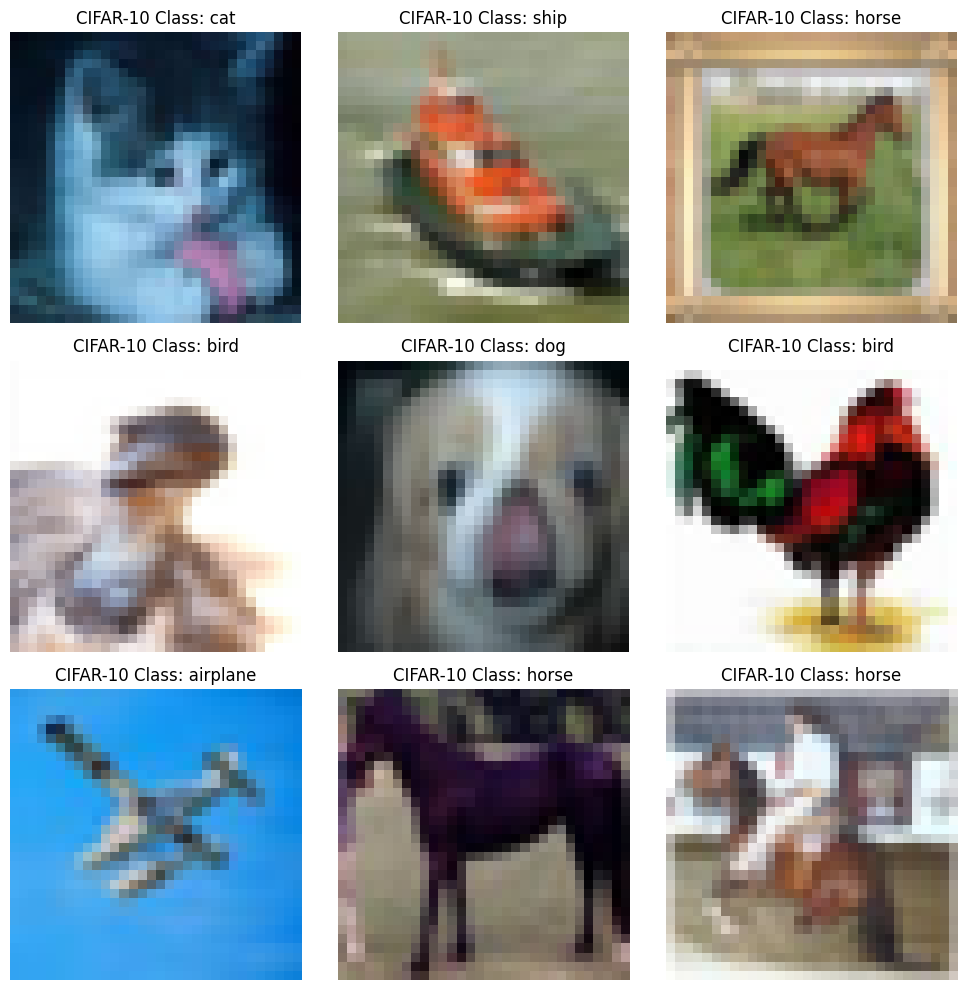

In [ ]:
# Define transforms for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset using torchvision
cifar10_train = CIFAR10(root='.', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='.', train=False, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

# Create data loaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

# Function to show random images
def show_random_images(dataset, class_names, ncols=3):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    random_indices = random.sample(range(len(dataset)), 9)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # (C, H, W) to (H, W, C)
        ax = axes.flat[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'CIFAR-10 Class: {class_names[label]}')

    plt.tight_layout()
    plt.show()


# Display random images with labels
show_random_images(train_dataset, cifar10_train.classes)


Function to create the model

In [ ]:
#Create the model

def create_model(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training and evaluation functions for the model.

In [ ]:
# Function to train the model
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10):
    losses = []
    accuracies = []
    for epoch in range(epochs):
        running_loss = 0.0

        # Training phase
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                current_batch = (i + 1) * batch_size
                total_images = len(train_loader.dataset)
                percent_complete = 100 * current_batch / total_images
                print(f'Training: Epoch [{epoch + 1}, {current_batch}/{total_images} ({percent_complete:.2f}%)], Loss: {running_loss / 10:.3f}')
                running_loss = 0.0

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, loss_fn, val_loader)
        losses.append(val_loss)
        accuracies.append(val_accuracy)
        print(f'End of Epoch {epoch + 1}. Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    print('Finished Training')
    return losses, accuracies

# Function to evaluate the model
def evaluate_model(model, loss_fn, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

Iteration over the epochs to see how the model performs on the training and test sets.

In [ ]:
epochs = 10

# Initial training
num_classes=len(cifar10_train.classes)

model = create_model(num_classes).to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_loss, training_accuracy = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs)

# Final evaluation on test set
test_loss, test_accuracy = evaluate_model(model, loss_fn, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training: Epoch [1, 1000/40000 (2.50%)], Loss: 2.052
Training: Epoch [1, 2000/40000 (5.00%)], Loss: 1.606
Training: Epoch [1, 3000/40000 (7.50%)], Loss: 1.461
...Training: Epoch [10, 39000/40000 (97.50%)], Loss: 0.122
Training: Epoch [10, 40000/40000 (100.00%)], Loss: 0.147
End of Epoch 10. Validation Loss: 0.8235, Validation Accuracy: 0.7905
Finished Training
Test Loss: 0.8758, Test Accuracy: 0.7836


Iteration over multiple different trainings over different epochs, to see the performance of the model as a function of the number of epochs.

Finally, a plot is computed to see the performance of the model.

In [ ]:
# Analyze performance as a function of epochs
testing_accuracies_epochs = []
testing_losses_epochs = []

for epoch in range(1, epochs + 1):
    model = create_model(num_classes).to(device)  # Reset the model
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reset the optimizer
    train_model(model, optimizer, loss_fn, train_loader, val_loader, epoch)
    test_loss, test_accuracy = evaluate_model(model, loss_fn, test_loader)
    testing_accuracies_epochs.append(test_accuracy)
    testing_losses_epochs.append(test_loss)
    print(f"Step {epoch} of {epochs}")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training: Epoch [1, 1000/40000 (2.50%)], Loss: 2.060
Training: Epoch [1, 2000/40000 (5.00%)], Loss: 1.516
Training: Epoch [1, 3000/40000 (7.50%)], Loss: 1.346
Training: Epoch [1, 4000/40000 (10.00%)], Loss: 1.325
Training: Epoch [1, 5000/40000 (12.50%)], Loss: 1.198
Training: Epoch [1, 6000/40000 (15.00%)], Loss: 1.103
Training: Epoch [1, 7000/40000 (17.50%)], Loss: 1.102
Training: Epoch [1, 8000/40000 (20.00%)], Loss: 1.123
Training: Epoch [1, 9000/40000 (22.50%)], Loss: 1.034
Training: Epoch [1, 10000/40000 (25.00%)], Loss: 0.989
Training: Epoch [1, 11000/40000 (27.50%)], Loss: 1.033
Training: Epoch [1, 12000/40000 (30.00%)], Loss: 0.966
Training: Epoch [1, 13000/40000 (32.50%)], Loss: 1.085
Training: Epoch [1, 14000/40000 (35.00%)], Loss: 0.934
Training: Epoch [1, 15000/40000 (37.50%)], Loss: 0.907
Training: Epoch [1, 16000/40000 (40.00%)], Loss: 0.878
Training: Epoch [1, 17000/40000 (42.50%)], Loss: 0.961
Training: Epoch [1, 18000/40000 (45.00%)], Loss: 0.865
Training: Epoch [1, 19

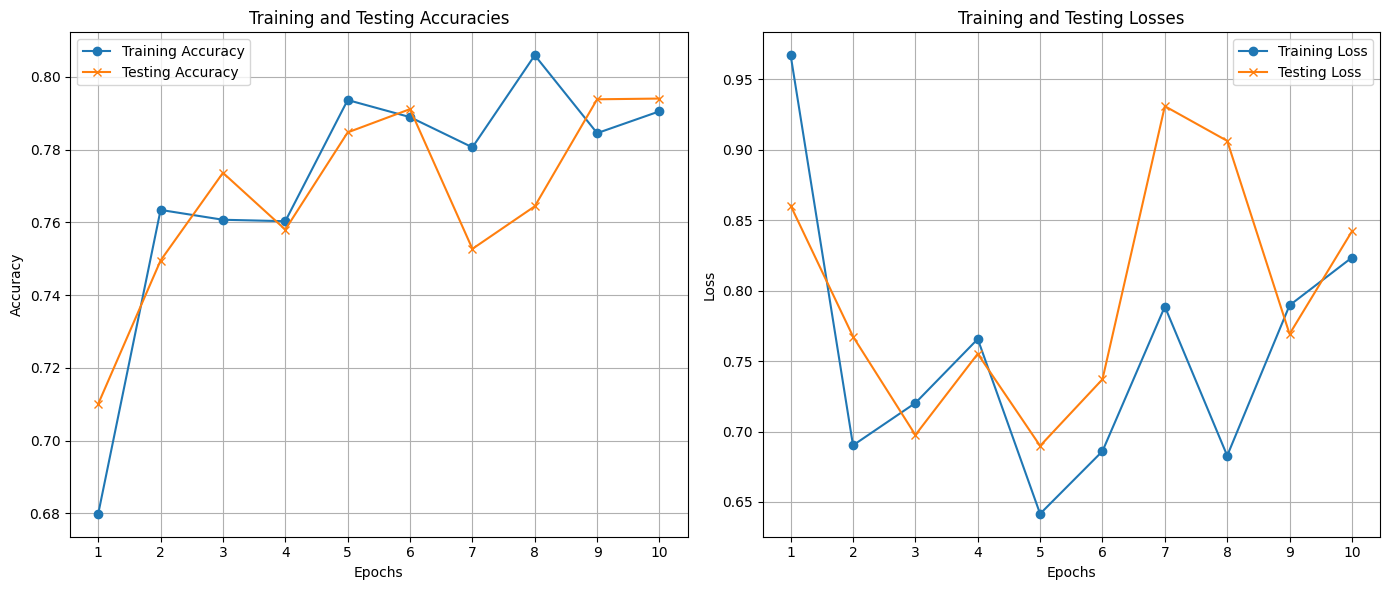

In [ ]:
# Create a figure and a set of subplots
x=np.linspace(1,10,epochs)

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracies
ax1.plot(x, training_accuracy, label='Training Accuracy', marker='o')
ax1.plot(x, testing_accuracies_epochs, label='Testing Accuracy', marker='x')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Testing Accuracies')
ax1.grid(True)
ax1.legend()
ax1.set_xticks(np.arange(1, epochs + 1))  # Set ticks at every integer point from 1 to epochs

# Plot losses
ax2.plot(x, training_loss, label='Training Loss', marker='o')
ax2.plot(x, testing_losses_epochs, label='Testing Loss', marker='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Testing Losses')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(np.arange(1, epochs + 1))  # Set ticks at every integer point from 1 to epochs

# Adjust layout for a better fit
plt.tight_layout()

# Show the plot
plt.show()

As we can see, the accuracy of the model has increased over the number of epochs that the model has been trained upon. Nonetheless, the training and testing losses do not decrease that much, but it does so a little. Tuning certain parameters further like the learning rate or adding factors like regularization might help.

As a conclusion, we have been able to see the robustness of a model like ResNet, which has performed with good accuracy once it has been trained on a dataset like the Cifar10.